<a href="https://colab.research.google.com/github/Smiley8866/Colab/blob/main/Test_RF_Adversarial_Clamp_Greedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/urwithajit9/ClaMP/refs/heads/master/dataset/ClaMP_Raw-5184.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1016k  100 1016k    0     0  5059k      0 --:--:-- --:--:-- --:--:-- 5084k


In [ ]:
!ls

ClaMP_Raw-5184.csv  sample_data


In [ ]:
import pandas as pd
db = pd.read_csv("ClaMP_Raw-5184.csv")
print(db.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_magic                      5184 non-null   int64  
 1   e_cblp                       5184 non-null   int64  
 2   e_cp                         5184 non-null   int64  
 3   e_crlc                       5184 non-null   int64  
 4   e_cparhdr                    5184 non-null   int64  
 5   e_minalloc                   5184 non-null   int64  
 6   e_maxalloc                   5184 non-null   int64  
 7   e_ss                         5184 non-null   int64  
 8   e_sp                         5184 non-null   int64  
 9   e_csum                       5184 non-null   int64  
 10  e_ip                         5184 non-null   int64  
 11  e_cs                         5184 non-null   int64  
 12  e_lfarlc                     5184 non-null   int64  
 13  e_ovno            

In [ ]:
legitimate = db[0:2501]
malware = db [2501:]

print(malware.take([1]))

print(legitimate.shape)
print(malware.shape)

      e_magic  e_cblp  e_cp  e_crlc  e_cparhdr  e_minalloc  e_maxalloc  e_ss  \
2502    23117     144     3       0          4           0       65535     0   

      e_sp  e_csum  ...  CheckSum  Subsystem  DllCharacteristics  \
2502   184       0  ...         0          2               32768   

      SizeOfStackReserve  SizeOfStackCommit  SizeOfHeapReserve  \
2502             1048576               4096            1048576   

      SizeOfHeapCommit  LoaderFlags  NumberOfRvaAndSizes  class  
2502              4096            0                   16      1  

[1 rows x 56 columns]
(2501, 56)
(2683, 56)


In [ ]:
data_in = db.drop(["class", "e_res", "e_res2"], axis=1).values
labels = db["class"].values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
)

legitimate_train, legitimate_test, mal_train, mal_test = train_test_split(data_in, labels, test_size=0.35)
model = RandomForestClassifier(n_estimators=53)

# Training
model.fit(legitimate_train, mal_train)

# Test
predicted = model.predict(legitimate_test)

# Accuracy
accuracy = accuracy_score(predicted, mal_test)
print("Accuracy: ", accuracy)

Accuracy:  0.9854090672225118


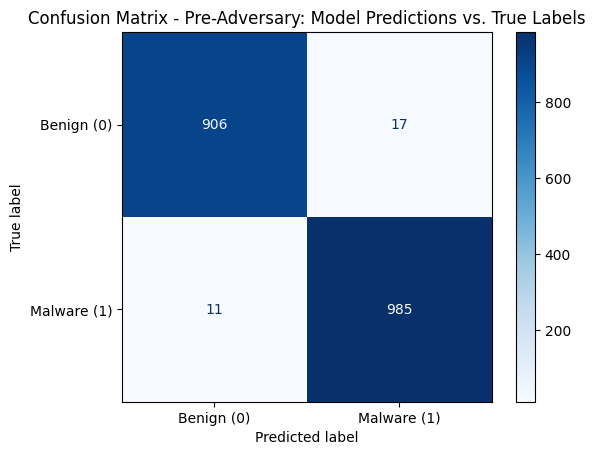

🧪 Evaluation Metrics:
Accuracy : 0.99
Precision: 0.98
Recall   : 0.99
F1 Score : 0.99


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt

# Labels for display
display_labels = ["Benign (0)", "Malware (1)"]

# Confusion matrix
cm = confusion_matrix(mal_test, predicted, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Pre-Adversary: Model Predictions vs. True Labels")
plt.show()

# Metrics
accuracy = accuracy_score(mal_test, predicted)
precision = precision_score(mal_test, predicted, zero_division=0)
recall = recall_score(mal_test, predicted, zero_division=0)
f1 = f1_score(mal_test, predicted, average="weighted", zero_division=0)

# Print results
print("🧪 Evaluation Metrics:")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

In [ ]:
import numpy as np
import collections

# Greedy attack
# Variable 1 - Max Change = [1, 5, 10]
def greedy_attack(sample, true_label, model, benign_pool, max_changes=10):
    original_prediction = model.predict(sample.reshape(1, -1))[0]
    if original_prediction != true_label:
        return sample, 0, True, [], None

    modified_sample = sample.copy()
    changed_features = []
    feature_order = np.argsort(model.feature_importances_)[::-1]

# Variable 2 - Step size [0.5, 0.25, 0.1]
    step_sizes = [0.1]

# Main Loop
    for _ in range(max_changes):
        best_sample = None
        best_feature = None

        for i in feature_order:
            if i in changed_features:
                continue

        # Local Best Candidate (best_local)
            best_local = None
            for step in step_sizes:
                for direction in [-1, 1]:
                    temp_sample = modified_sample.copy()
                    temp_sample[i] = np.clip(temp_sample[i] + direction * step, 0, 1)
                    new_pred = model.predict(temp_sample.reshape(1, -1))[0]
                    if new_pred != true_label:
                        return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
                    if best_local is None:
                        best_local = temp_sample

        # Replacement iwth Benign Pool Values
            replacement_value = benign_pool[np.random.randint(0, len(benign_pool))][i]
            temp_sample = modified_sample.copy()
            temp_sample[i] = replacement_value
            new_pred = model.predict(temp_sample.reshape(1, -1))[0]
            if new_pred != true_label:
                return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
            if best_sample is None:
                best_sample = temp_sample
                best_feature = i

        if best_sample is not None:
            modified_sample = best_sample
            changed_features.append(best_feature)

    return modified_sample, len(changed_features), False, changed_features, None

# Prepare test set
X_test = legitimate_test
y_test = mal_test

benign_pool = X_test[y_test == 0]

# Attack loop and data collection
malware_indices = np.where(y_test == 1)[0]
success = 0
attempts = min(1000, len(malware_indices))

adv_samples = []
adv_labels = []
original_preds = []
changed_feature_log = []
impactful_features = []

# Main Attack Loop
for i in range(attempts):
    idx = malware_indices[i]
    sample = X_test[idx]
    label = y_test[idx]
    adv_sample, changes, succeeded, changed_feats, first_success_feature = greedy_attack(sample, label, model, benign_pool)

    # Post-Attack Analysis
    if succeeded:
        pred_before = model.predict(adv_sample.reshape(1, -1))[0]
        adv_samples.append(adv_sample)
        adv_labels.append(label)
        original_preds.append(pred_before)
        changed_feature_log.extend(changed_feats)
        if first_success_feature is not None:
            impactful_features.append(first_success_feature)
        print(f"✅ Sample {i}: malware evaded after {changes} modifications")
        success += 1
    else:
        print(f"❌ Sample {i}: attack failed")

print(f"\n📊 Malware Evasion Success Rate: {success}/{attempts}")

# Feature metadata
feature_names = db.drop(["class", "e_res", "e_res2"], axis=1).columns

# Top modified features
mod_counts = collections.Counter(changed_feature_log).most_common(10)
print("\n🔬 Top 10 Most Frequently Modified Features:")
for idx, count in mod_counts:
    print(f"{feature_names[idx]} (index {idx}) — modified {count} times")

# Most impactful features (modified first and led to success)
impact_counts = collections.Counter(impactful_features).most_common(10)
print("\n💥 Top 10 Most Impactful Features (single change led to evasion):")
for idx, count in impact_counts:
    print(f"{feature_names[idx]} (index {idx}) — first change led to evasion {count} times")

✅ Sample 0: malware evaded after 1 modifications
✅ Sample 1: malware evaded after 3 modifications
✅ Sample 2: malware evaded after 3 modifications
✅ Sample 3: malware evaded after 8 modifications
✅ Sample 4: malware evaded after 2 modifications
✅ Sample 5: malware evaded after 2 modifications
✅ Sample 6: malware evaded after 1 modifications
✅ Sample 7: malware evaded after 2 modifications
✅ Sample 8: malware evaded after 4 modifications
✅ Sample 9: malware evaded after 2 modifications
✅ Sample 10: malware evaded after 5 modifications
✅ Sample 11: malware evaded after 4 modifications
✅ Sample 12: malware evaded after 1 modifications
✅ Sample 13: malware evaded after 2 modifications
✅ Sample 14: malware evaded after 1 modifications
✅ Sample 15: malware evaded after 2 modifications
✅ Sample 16: malware evaded after 1 modifications
✅ Sample 17: malware evaded after 0 modifications
✅ Sample 18: malware evaded after 10 modifications
✅ Sample 19: malware evaded after 2 modifications
✅ Sample 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Combine Original Data with Adversarial Samples
# After the greedy attack loop, we have adv_samples (adversarial samples) and adv_labels (adversarial labels).
X_train_augmented = np.vstack([legitimate_train, adv_samples])
y_train_augmented = np.hstack([mal_train, adv_labels])

# Retrain the Model
model_advtrained = RandomForestClassifier(n_estimators=53, random_state=42, class_weight='balanced')
model_advtrained.fit(X_train_augmented, y_train_augmented)

# Generate Classification Report
print("📊 Adversarial Evaluation Metrics (Before Retraining):\n")
present_labels = [0, 1]
print(classification_report(
    adv_labels,
    original_preds,
    labels=present_labels,
    target_names=["Benign", "Malware"],
    zero_division=0
))

# Calculate and Display Additional Metrics (Before Retraining)
accuracy = accuracy_score(adv_labels, original_preds)
precision = precision_score(adv_labels, original_preds, pos_label=1, zero_division=0)
recall = recall_score(adv_labels, original_preds, pos_label=1, zero_division=0)
f1 = f1_score(adv_labels, original_preds, pos_label=1, zero_division=0)

# Display the results
print("\nAdditional Evaluation Metrics (Before Retraining):")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("Model has been retrained with adversarial samples.")

📊 Adversarial Evaluation Metrics (Before Retraining):

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       0.0
     Malware       0.00      0.00      0.00     966.0

    accuracy                           0.00     966.0
   macro avg       0.00      0.00      0.00     966.0
weighted avg       0.00      0.00      0.00     966.0


Additional Evaluation Metrics (Before Retraining):
Accuracy : 0.00
Precision: 0.00
Recall   : 0.00
F1 Score : 0.00
Model has been retrained with adversarial samples.


In [ ]:
/import numpy as np
import collections

# Greedy attack - Round 2
# Variable 1 - Max Change = [1, 5, 10]
def greedy_attack(sample, true_label, model, benign_pool, max_changes=10):
    original_prediction = model.predict(sample.reshape(1, -1))[0]
    if original_prediction != true_label:
        return sample, 0, True, [], None

    modified_sample = sample.copy()
    changed_features = []
    feature_order = np.argsort(model.feature_importances_)[::-1]

# Variable 2 - Step size [0.5, 0.25, 0.1]
    step_sizes = [0.1]

# Main Loop
    for _ in range(max_changes):
        best_sample = None
        best_feature = None

        for i in feature_order:
            if i in changed_features:
                continue

        # Local Best Candidate (best_local)
            best_local = None
            for step in step_sizes:
                for direction in [-1, 1]:
                    temp_sample = modified_sample.copy()
                    temp_sample[i] = np.clip(temp_sample[i] + direction * step, 0, 1)
                    new_pred = model.predict(temp_sample.reshape(1, -1))[0]
                    if new_pred != true_label:
                        return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
                    if best_local is None:
                        best_local = temp_sample

        # Replacement iwth Benign Pool Values
            replacement_value = benign_pool[np.random.randint(0, len(benign_pool))][i]
            temp_sample = modified_sample.copy()
            temp_sample[i] = replacement_value
            new_pred = model.predict(temp_sample.reshape(1, -1))[0]
            if new_pred != true_label:
                return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
            if best_sample is None:
                best_sample = temp_sample
                best_feature = i

        if best_sample is not None:
            modified_sample = best_sample
            changed_features.append(best_feature)

    return modified_sample, len(changed_features), False, changed_features, None

# Prepare test set
X_test = legitimate_test
y_test = mal_test

benign_pool = X_test[y_test == 0]

# Attack loop and data collection
malware_indices = np.where(y_test == 1)[0]
success = 0
attempts = min(1000, len(malware_indices))

adv_samples = []
adv_labels = []
original_preds = []
changed_feature_log = []
impactful_features = []

# Main Attack Loop
for i in range(attempts):
    idx = malware_indices[i]
    sample = X_test[idx]
    label = y_test[idx]
    adv_sample, changes, succeeded, changed_feats, first_success_feature = greedy_attack(sample, label, model, benign_pool)

    # Post-Attack Analysis
    if succeeded:
        pred_before = model.predict(adv_sample.reshape(1, -1))[0]
        adv_samples.append(adv_sample)
        adv_labels.append(label)
        original_preds.append(pred_before)
        changed_feature_log.extend(changed_feats)
        if first_success_feature is not None:
            impactful_features.append(first_success_feature)
        print(f"✅ Sample {i}: malware evaded after {changes} modifications")
        success += 1
    else:
        print(f"❌ Sample {i}: attack failed")

print(f"\n📊 Malware Evasion Success Rate: {success}/{attempts}")

# Feature metadata
feature_names = db.drop(["class", "e_res", "e_res2"], axis=1).columns

# Top modified features
mod_counts = collections.Counter(changed_feature_log).most_common(10)
print("\n🔬 Top 10 Most Frequently Modified Features:")
for idx, count in mod_counts:
    print(f"{feature_names[idx]} (index {idx}) — modified {count} times")

# Most impactful features (modified first and led to success)
impact_counts = collections.Counter(impactful_features).most_common(10)
print("\n💥 Top 10 Most Impactful Features (single change led to evasion):")
for idx, count in impact_counts:
    print(f"{feature_names[idx]} (index {idx}) — first change led to evasion {count} times")

✅ Sample 0: malware evaded after 1 modifications
✅ Sample 1: malware evaded after 1 modifications
✅ Sample 2: malware evaded after 2 modifications
✅ Sample 3: malware evaded after 2 modifications
✅ Sample 4: malware evaded after 1 modifications
✅ Sample 5: malware evaded after 4 modifications
✅ Sample 6: malware evaded after 1 modifications
✅ Sample 7: malware evaded after 4 modifications
✅ Sample 8: malware evaded after 2 modifications
✅ Sample 9: malware evaded after 2 modifications
✅ Sample 10: malware evaded after 1 modifications
✅ Sample 11: malware evaded after 4 modifications
✅ Sample 12: malware evaded after 1 modifications
✅ Sample 13: malware evaded after 2 modifications
✅ Sample 14: malware evaded after 1 modifications
✅ Sample 15: malware evaded after 5 modifications
✅ Sample 16: malware evaded after 1 modifications
✅ Sample 17: malware evaded after 0 modifications
✅ Sample 18: malware evaded after 8 modifications
✅ Sample 19: malware evaded after 2 modifications
✅ Sample 2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Combine Original Data with Adversarial Samples
# After the greedy attack loop, we have adv_samples (adversarial samples) and adv_labels (adversarial labels).
X_train_augmented = np.vstack([legitimate_train, adv_samples])
y_train_augmented = np.hstack([mal_train, adv_labels])

# Retrain the Model
model_advtrained = RandomForestClassifier(n_estimators=53, random_state=42, class_weight='balanced')
model_advtrained.fit(X_train_augmented, y_train_augmented)

# Generate Classification Report
print("📊 Adversarial Evaluation Metrics (Before Retraining):\n")
present_labels = [0, 1]
print(classification_report(
    adv_labels,
    original_preds,
    labels=present_labels,
    target_names=["Benign", "Malware"],
    zero_division=0
))

# Calculate and Display Additional Metrics (Before Retraining)
accuracy = accuracy_score(adv_labels, original_preds)
precision = precision_score(adv_labels, original_preds, pos_label=1, zero_division=0)
recall = recall_score(adv_labels, original_preds, pos_label=1, zero_division=0)
f1 = f1_score(adv_labels, original_preds, pos_label=1, zero_division=0)

# Display the results
print("\nAdditional Evaluation Metrics (Before Retraining):")
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("Model has been retrained with adversarial samples.")

📊 Adversarial Evaluation Metrics (Before Retraining):

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       0.0
     Malware       0.00      0.00      0.00     961.0

    accuracy                           0.00     961.0
   macro avg       0.00      0.00      0.00     961.0
weighted avg       0.00      0.00      0.00     961.0


Additional Evaluation Metrics (Before Retraining):
Accuracy : 0.00
Precision: 0.00
Recall   : 0.00
F1 Score : 0.00
Model has been retrained with adversarial samples.


In [ ]:
import numpy as np
import collections

# Greedy attack - Round 3
# Variable 1 - Max Change = [1, 5, 10]
def greedy_attack(sample, true_label, model, benign_pool, max_changes=2):
    original_prediction = model.predict(sample.reshape(1, -1))[0]
    if original_prediction != true_label:
        return sample, 0, True, [], None

    modified_sample = sample.copy()
    changed_features = []
    feature_order = np.argsort(model.feature_importances_)[::-1]

# Variable 2 - Step size [0.5, 0.25, 0.1]
    step_sizes = [0.1]

# Main Loop
    for _ in range(max_changes):
        best_sample = None
        best_feature = None

        for i in feature_order:
            if i in changed_features:
                continue

        # Local Best Candidate (best_local)
            best_local = None
            for step in step_sizes:
                for direction in [-1, 1]:
                    temp_sample = modified_sample.copy()
                    temp_sample[i] = np.clip(temp_sample[i] + direction * step, 0, 1)
                    new_pred = model.predict(temp_sample.reshape(1, -1))[0]
                    if new_pred != true_label:
                        return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
                    if best_local is None:
                        best_local = temp_sample

        # Replacement iwth Benign Pool Values
            replacement_value = benign_pool[np.random.randint(0, len(benign_pool))][i]
            temp_sample = modified_sample.copy()
            temp_sample[i] = replacement_value
            new_pred = model.predict(temp_sample.reshape(1, -1))[0]
            if new_pred != true_label:
                return temp_sample, len(changed_features) + 1, True, changed_features + [i], i
            if best_sample is None:
                best_sample = temp_sample
                best_feature = i

        if best_sample is not None:
            modified_sample = best_sample
            changed_features.append(best_feature)

    return modified_sample, len(changed_features), False, changed_features, None

# Prepare test set
X_test = legitimate_test
y_test = mal_test

benign_pool = X_test[y_test == 0]

# Attack loop and data collection
malware_indices = np.where(y_test == 1)[0]
success = 0
attempts = min(1000, len(malware_indices))

adv_samples = []
adv_labels = []
original_preds = []
changed_feature_log = []
impactful_features = []

# Main Attack Loop
for i in range(attempts):
    idx = malware_indices[i]
    sample = X_test[idx]
    label = y_test[idx]
    adv_sample, changes, succeeded, changed_feats, first_success_feature = greedy_attack(sample, label, model, benign_pool)

    # Post-Attack Analysis
    if succeeded:
        pred_before = model.predict(adv_sample.reshape(1, -1))[0]
        adv_samples.append(adv_sample)
        adv_labels.append(label)
        original_preds.append(pred_before)
        changed_feature_log.extend(changed_feats)
        if first_success_feature is not None:
            impactful_features.append(first_success_feature)
        print(f"✅ Sample {i}: malware evaded after {changes} modifications")
        success += 1
    else:
        print(f"❌ Sample {i}: attack failed")

print(f"\n📊 Malware Evasion Success Rate: {success}/{attempts}")

# Feature metadata
feature_names = db.drop(["class", "e_res", "e_res2"], axis=1).columns

# Top modified features
mod_counts = collections.Counter(changed_feature_log).most_common(10)
print("\n🔬 Top 10 Most Frequently Modified Features:")
for idx, count in mod_counts:
    print(f"{feature_names[idx]} (index {idx}) — modified {count} times")

# Most impactful features (modified first and led to success)
impact_counts = collections.Counter(impactful_features).most_common(10)
print("\n💥 Top 10 Most Impactful Features (single change led to evasion):")
for idx, count in impact_counts:
    print(f"{feature_names[idx]} (index {idx}) — first change led to evasion {count} times")

✅ Sample 0: malware evaded after 1 modifications
❌ Sample 1: attack failed
✅ Sample 2: malware evaded after 2 modifications
✅ Sample 3: malware evaded after 2 modifications
❌ Sample 4: attack failed
✅ Sample 5: malware evaded after 2 modifications
✅ Sample 6: malware evaded after 1 modifications
✅ Sample 7: malware evaded after 1 modifications
❌ Sample 8: attack failed
✅ Sample 9: malware evaded after 2 modifications
❌ Sample 10: attack failed
✅ Sample 11: malware evaded after 2 modifications
❌ Sample 12: attack failed
✅ Sample 13: malware evaded after 1 modifications
✅ Sample 14: malware evaded after 1 modifications
✅ Sample 15: malware evaded after 1 modifications
✅ Sample 16: malware evaded after 1 modifications
✅ Sample 17: malware evaded after 0 modifications
❌ Sample 18: attack failed
✅ Sample 19: malware evaded after 2 modifications
❌ Sample 20: attack failed
✅ Sample 21: malware evaded after 1 modifications
❌ Sample 22: attack failed
✅ Sample 23: malware evaded after 1 modifica

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git
